<a href="https://colab.research.google.com/github/ahmedbellaaj10/TP_ML_avance/blob/main/Lab_DL__RNN_CLASS__keras__2021_10_05__imdb__student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Deep Learning/ Recurrent Neural Networks/ in keras

## Using Many-to-One for movie rating predicton

**Author: geoffroy.peeters@telecom-paris.fr**

**Version**: 2021/10/05 (changed to tensorfow.keras)

For any remark or suggestion, please feel free to contact me.

## Objective:
We will implement two different networks to perform automatic rating (0 or 1) of a movie given the text of its review.
We will use the ```imdb``` (internet movie database) dataset.

The reviews are already available in the form of indexes that point to a word dictionary: each word is already encoded as an index in the dictionary.

## Import packages

In [48]:
import numpy as np
from tensorflow.keras.datasets import imdb

from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense, Activation, Embedding, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector

colab = True
student = True

## Parameters of the model

-  We only consider the ```top_words``` first words in the word dictionary
- We truncate/zero-pad each sequence a length ```max_review_length```

In [49]:
top_words = 5000
max_review_length = 100
INDEX_FROM = 3
embedding_vector_length = 32

## Import IMDB data

In [50]:
# --- Import the IMDB data and only consider the ``top_words``` most used words
np.load.__defaults__=(None, True, True, 'ASCII')
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words, index_from=INDEX_FROM)
np.load.__defaults__=(None, False, True, 'ASCII')

## Data content

- ```X_train``` and ```X_test``` are numpy arrays of lists.
  - each item in a list is the index in the word dictionary. So that a list is the sequence of index of words.

- ```y_train``` and ```y_test``` are a numpy arrays of the same dimension as ```X_train``` and ```X_test```
  - they contains the values 0 (bad movie) or 1 (good movie)

type(X_train): <class 'numpy.ndarray'>
number of training sequences: X_train.shape: (25000,)
type(X_train[0]): <class 'list'>
length of the first training sequence: len(X_train[0]): 218
length of the second training sequence: len(X_train[1]): 189
list of data of the first training sequence: X_train[0]: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 

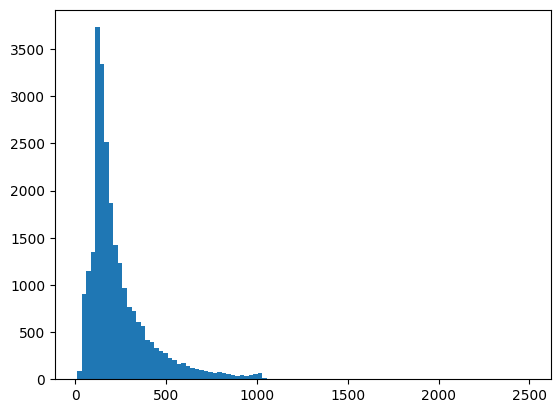

In [51]:
print("type(X_train):", type(X_train))
print("number of training sequences: X_train.shape:", X_train.shape)
print("type(X_train[0]):",type(X_train[0]))
print("length of the first training sequence: len(X_train[0]):",len(X_train[0]))
print("length of the second training sequence: len(X_train[1]):",len(X_train[1]))
print("list of data of the first training sequence: X_train[0]:", X_train[0] )
len_list = [len(train) for train in X_train]
print("maximum length of a training sequence:", max(len_list))

import matplotlib.pyplot as plt
plt.hist(len_list, 100);

## Details of how the reviews are encoded

In [52]:
word_to_id = imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in X_train[1000] ))

<START> although i had seen <UNK> in a theater way back in <UNK> i couldn't remember anything of the plot except for vague images of kurt thomas running and fighting against a backdrop of stone walls and disappointment regarding the ending br br after reading some of the other reviews i picked up a copy of the newly released dvd to once again enter the world of <UNK> br br it turns out this is one of those films produced during the <UNK> that would go directly to video today the film stars <UNK> <UNK> kurt thomas as jonathan <UNK> <UNK> out of the blue to <UNK> the nation of <UNK> to enter and hopefully win the game a <UNK> <UNK> <UNK> by the khan who <UNK> his people by yelling what sounds like <UNK> power the goal of the mission involves the star wars defense system jonathan is trained in the martial arts by princess <UNK> who never speaks or leaves the house once trained tries to blend in with the <UNK> by wearing a bright red <UNK> with <UNK> of blue and white needless to say <UNK>

In [53]:
print("type(y_train):", type(y_train))
print("y_train.shape:", y_train.shape)

type(y_train): <class 'numpy.ndarray'>
y_train.shape: (25000,)


In [54]:
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_test.shape: (25000,)
y_test.shape: (25000,)


## Data processing

Sequences (represented as a list of values) in ```X_train``` represent the reviews.
They can have different length.
To train the network we should modify them so that they all have the same length.
We do this by:
- truncating the ones that are too long
- padding-with-zero them the ones that are too short.

This is obtained using ```sequence.pad_sequences``` of keras.

In [55]:
# --- truncate and pad input sequences
import keras

if student:
    X_train = keras.utils.pad_sequences(
    X_train,
    maxlen=max_review_length,
    dtype='int32',
    padding='pre',
    truncating='pre',
    value=0
    )
    X_test = keras.utils.pad_sequences(
    X_test,
    maxlen=max_review_length,
    dtype='int32',
    padding='pre',
    truncating='pre',
    value=0
    )
    # --- START CODE HERE (01)
    ...
    # --- END CODE HERE

print("len(X_train[0]):", len(X_train[0]))
print("len(X_train[1]):", len(X_train[1]))
print("X_train[0]:", X_train[1])

len(X_train[0]): 100
len(X_train[1]): 100
X_train[0]: [ 163   11 3215    2    4 1153    9  194  775    7    2    2  349 2637
  148  605    2    2   15  123  125   68    2    2   15  349  165 4362
   98    5    4  228    9   43    2 1157   15  299  120    5  120  174
   11  220  175  136   50    9 4373  228    2    5    2  656  245 2350
    5    4    2  131  152  491   18    2   32    2 1212   14    9    6
  371   78   22  625   64 1382    9    8  168  145   23    4 1690   15
   16    4 1355    5   28    6   52  154  462   33   89   78  285   16
  145   95]


In [56]:
X_train.shape

(25000, 100)

# First model

<img src="https://perso.telecom-paristech.fr/gpeeters/doc/Lab_DL_RNN_01.png">

In the first model, we will simply
- learn a word embedding  (```Embedding``` layer in keras) and apply it to each item of the sequence,
  -  in keras, embedding is not a matrix going from one-hot-encoding to embedding, but is a layer that goes from index-in-word-dictionary to embedding
  - the embedding goes from ```top_words``` dimensions to  ```embedding_vector_length``` dimensions
- average the embedding obtained for each word of a sequence over all words of the sequence (you should use ```K.mean``` and ```Lambda``` from the keras backend)
- apply a fully connected (```Dense``` layer in keras) which output activation is a sigmoid (predicting the 0 or 1 rating)

We will code this model
- First, using the Sequential API of keras (https://keras.io/models/sequential/)
- Secondly, using the Functional API of keras (https://keras.io/getting-started/functional-api-guide/)


In [57]:
K.clear_session()

In [58]:
len(X_train[4])

100

In [59]:
top_words = 5000
max_review_length = 100
INDEX_FROM = 3
embedding_vector_length = 32

In [60]:
# --- create the model
# CODE-RNN1-2
if student:
    # --- START CODE HERE (02)
    # --- Using the Sequential API
    model = Sequential()
    # model.add(Input(shape=(max_review_length,)))
    model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
    model.add(Lambda(lambda x: K.mean(x, axis=1)))
    # model.add(Lambda(lambda x: K.mean(x)))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    ...
    # --- END CODE HERE

    # --- START CODE HERE (03)
    # --- Using the Functional API
    ...
    # --- END CODE HERE

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           160000    
                                                                 
 lambda (Lambda)             (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [61]:
# X_train = np.array(X_train)
# X_test = np.array(X_test)
# y_train = np.array(y_train)
# y_test = np.array(y_test)

X_train[0]

array([1415,   33,    6,   22,   12,  215,   28,   77,   52,    5,   14,
        407,   16,   82,    2,    8,    4,  107,  117,    2,   15,  256,
          4,    2,    7, 3766,    5,  723,   36,   71,   43,  530,  476,
         26,  400,  317,   46,    7,    4,    2, 1029,   13,  104,   88,
          4,  381,   15,  297,   98,   32, 2071,   56,   26,  141,    6,
        194,    2,   18,    4,  226,   22,   21,  134,  476,   26,  480,
          5,  144,   30,    2,   18,   51,   36,   28,  224,   92,   25,
        104,    4,  226,   65,   16,   38, 1334,   88,   12,   16,  283,
          5,   16, 4472,  113,  103,   32,   15,   16,    2,   19,  178,
         32], dtype=int32)

In [62]:
import tensorflow as tf
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.int8)
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.int8)

In [63]:
# --- compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_tf, y_train, epochs=3, batch_size=64, validation_data=(X_test_tf, y_test))

Epoch 1/3
391/391 [==============================] - 4s 7ms/step - loss: 0.6694 - accuracy: 0.6385 - val_loss: 0.6383 - val_accuracy: 0.6602
Epoch 2/3
391/391 [==============================] - 2s 5ms/step - loss: 0.6109 - accuracy: 0.6810 - val_loss: 0.5930 - val_accuracy: 0.6875
Epoch 3/3
391/391 [==============================] - 3s 6ms/step - loss: 0.5828 - accuracy: 0.6951 - val_loss: 0.5782 - val_accuracy: 0.6935


## Results

After only 3 epochs, you should obtain an accuracy around 83-84% for the test data.

In [64]:
# --- Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 68.04%


## Using the trained embedding to find equivalence between words

Since the embedding is part of the models, we can look at the trained embedding matrix $E$ and use it to get the most similar words (according to the trained matrix $E$) in the dictionary.
Use the weights of the ```Embedding``` layer to find the most similar words to ```great```. We will use an Euclidean distance for that.
- Retrieve the weights of the ```Embedding layer```
- Get the position of ```great``` in the dictionary
- Get the word-embedding of ```great```
- Find (using Euclidean distance), the closest embedded-words to ```great```

In [68]:
model.layers[0].get_weights()# [0].shape

[array([[-0.05039876,  0.03491502, -0.00456951, ...,  0.05381323,
         -0.02697828, -0.03344515],
        [-0.26746938,  0.27718496, -0.35438618, ...,  0.29282212,
          0.35783687, -0.31881604],
        [ 0.0354566 ,  0.01855964,  0.03953954, ..., -0.06073724,
         -0.05756662,  0.0500406 ],
        ...,
        [ 0.00788124, -0.01378564, -0.0267291 , ...,  0.00871025,
         -0.0331553 ,  0.03128997],
        [ 0.04944715, -0.01748539, -0.02958041, ..., -0.02042381,
          0.03812034,  0.03184513],
        [-0.0262017 , -0.02479223, -0.03007511, ..., -0.04437374,
         -0.03960575,  0.0469785 ]], dtype=float32)]

{'fawn': 34704,
 'tsukino': 52009,
 'nunnery': 52010,
 'sonja': 16819,
 'vani': 63954,
 'woods': 1411,
 'spiders': 16118,
 'hanging': 2348,
 'woody': 2292,
 'trawling': 52011,
 "hold's": 52012,
 'comically': 11310,
 'localized': 40833,
 'disobeying': 30571,
 "'royale": 52013,
 "harpo's": 40834,
 'canet': 52014,
 'aileen': 19316,
 'acurately': 52015,
 "diplomat's": 52016,
 'rickman': 25245,
 'arranged': 6749,
 'rumbustious': 52017,
 'familiarness': 52018,
 "spider'": 52019,
 'hahahah': 68807,
 "wood'": 52020,
 'transvestism': 40836,
 "hangin'": 34705,
 'bringing': 2341,
 'seamier': 40837,
 'wooded': 34706,
 'bravora': 52021,
 'grueling': 16820,
 'wooden': 1639,
 'wednesday': 16821,
 "'prix": 52022,
 'altagracia': 34707,
 'circuitry': 52023,
 'crotch': 11588,
 'busybody': 57769,
 "tart'n'tangy": 52024,
 'burgade': 14132,
 'thrace': 52026,
 "tom's": 11041,
 'snuggles': 52028,
 'francesco': 29117,
 'complainers': 52030,
 'templarios': 52128,
 '272': 40838,
 '273': 52031,
 'zaniacs': 52133,

In [66]:
if student:
    # --- START CODE HERE (04)
    emb_weights = model.layers[0].get_weights()
    pos = word_to_id['great']
    # --- END CODE HERE
for i in np.argsort(dist_v)[0:20]: print(id_to_word[i])

NameError: name 'dist_v' is not defined

# Second model

In the second model, we will replace
- the average over the sequence of the obtained embedding
- by a RNN layer (more precisely an ```LSTM```) in a Many-To-One configuration with $n_a=128$

We will code this model
- First, using the Sequential API of keras (https://keras.io/models/sequential/)
- Secondly, using the Functional API of keras (https://keras.io/getting-started/functional-api-guide/)



In [ ]:
K.clear_session()

In [ ]:
# --- create the model

if student:
    # --- START CODE HERE (05)
    # --- Using the Sequential API
    ...
    # --- END CODE HERE

    # --- START CODE HERE (06)
    # --- Using the Functional API
    #model = ...
    # --- END CODE HERE

print(model.summary())

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 100, 32)           160000    
                                                                 
 lstm_13 (LSTM)              (None, 128)               82432     
                                                                 
 dense_19 (Dense)            (None, 1)                 129       
                                                                 
 activation_16 (Activation)  (None, 1)                 0         
                                                                 
Total params: 242561 (947.50 KB)
Trainable params: 242561 (947.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# --- compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/3
391/391 [==============================] - 28s 62ms/step - loss: 0.4480 - accuracy: 0.7796 - val_loss: 0.3460 - val_accuracy: 0.8487
Epoch 2/3
391/391 [==============================] - 8s 20ms/step - loss: 0.3075 - accuracy: 0.8718 - val_loss: 0.3634 - val_accuracy: 0.8445
Epoch 3/3
391/391 [==============================] - 8s 20ms/step - loss: 0.2736 - accuracy: 0.8888 - val_loss: 0.3553 - val_accuracy: 0.8470


## Results

After only 3 epochs, you should obtain an accuracy around 84-85% for the test data.

In [ ]:
# --- Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

# Evaluation

To evaluate the work, you should rate the code for
- 1) Data Pre-Processing (01)
- 2) First model using the Sequential API (02)
- 3) First model using the Functional API (03)
- 4) Find equivalence between words (04)
- 5) Second model using the Sequential API (05)
- 6) Second model using the Functional API (06)
